In [ ]:
import pickle
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

In [2]:
# load xgboost model in .xgb file
def load_xgboost_model(model_path):
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        return model
    except Exception as e:
        print(f"Error loading model with pickle: {e}")
        try:
            # Try loading with XGBoost's built-in method
            model = XGBRegressor()
            model.load_model(model_path)
            return model
        except Exception as e2:
            print(f"Error loading with XGBoost method: {e2}")
            return None

# Use raw string to avoid escape character issues
model_path = r'D:\H.U.S.T\Machine Learning\Remake Stock FInal\models_store\GSPC_xgboost_regression.xgb'
model = load_xgboost_model(model_path)


Error loading model with pickle: invalid load key, '{'.


In [3]:
df = pd.read_csv('../data/sp500_stock_prices_2000_2025.csv', index_col='Date', parse_dates=True, skiprows=[1]).drop(columns=['Adj Close', 'Volume', 'High', 'Low','Open'])
INPUT_FEATURES = [f'Close_lag_{i}' for i in range(1, 14 + 1)] +[f'{'Close'}_pct_change_1d']
TARGET_COLUMN = 'Close'
df['target_pct_change'] = df[TARGET_COLUMN].pct_change().shift(-1)
df.dropna(inplace=True)

In [4]:
# 1. Create Lag Features
LAG_DAYS = 14
target_col = 'Close'
for i in range(1, LAG_DAYS + 1):
    feature_name = f'{target_col}_lag_{i}'
    df[feature_name] = df[target_col].shift(i)

# 2. Create Percentage Change Feature
# (Today's target_col - Yesterday's target_col) / Yesterday's target_col
df['Close_pct_change_1d'] = df[target_col].pct_change()

# 3. Create 'close_target' (next day's target_col value)
df['close_target'] = df[target_col].shift(-1)

# 4. Drop rows with NaNs created by shifting (for lags, pct_change, and close_target)
df.dropna(inplace=True)

In [5]:
X_trad = df[INPUT_FEATURES].copy()
y_trad = df['target_pct_change'].copy()
split_idx_trad = int(len(X_trad) * 0.8)
X_train_trad, X_test_trad = X_trad.iloc[:split_idx_trad], X_trad.iloc[split_idx_trad:]
y_train_trad, y_test_trad = y_trad.iloc[:split_idx_trad], y_trad.iloc[split_idx_trad:]


In [6]:
param_grid_rf = {
        'n_estimators': [100, 150, 200 ,300],
        'max_depth': [15, 20, 12,None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 1.0],
        'random_state': [42,43,44],
    }

rf = RandomForestRegressor(n_jobs=-1)
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


time_series_cv = TimeSeriesSplit(n_splits=10, gap=0)

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                                  cv=time_series_cv, # SỬ DỤNG TimeSeriesSplit Ở ĐÂY
                                  scoring='neg_mean_squared_error',
                                  verbose=2,
                                  n_jobs=-1)

In [7]:
grid_search_rf.fit(X_train_trad, y_train_trad)

Fitting 10 folds for each of 864 candidates, totalling 8640 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'max_depth': [15, 20, 12, None],
                         'max_features': ['sqrt', 1.0],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 150, 200, 300],
                         'random_state': [42, 43, 44]},
             scoring='neg_mean_squared_error', verbose=2)

In [8]:
print("Best parameters found: ", grid_search_rf.best_params_)
print("Best score (negative MSE): ", grid_search_rf.best_score_)

Best parameters found:  {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 44}
Best score (negative MSE):  -0.00016123744502275815


In [9]:
# gspc_rf = RandomForestRegressor(**{'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}, n_jobs=-1)
gspc_rf = RandomForestRegressor(**grid_search_rf.best_params_, n_jobs=-1)
gspc_rf.fit(X_train_trad, y_train_trad)


RandomForestRegressor(max_depth=12, max_features='sqrt', min_samples_leaf=4,
                      n_jobs=-1, random_state=44)

In [10]:
y_pred_pct_change_test = model.predict(X_test_trad)
last_actual_close_for_test_samples = df.loc[X_test_trad.index, TARGET_COLUMN]
y_test_absolute_actual = df.loc[X_test_trad.index, 'close_target']
y_pred_absolute_test = last_actual_close_for_test_samples * (1 + y_pred_pct_change_test)


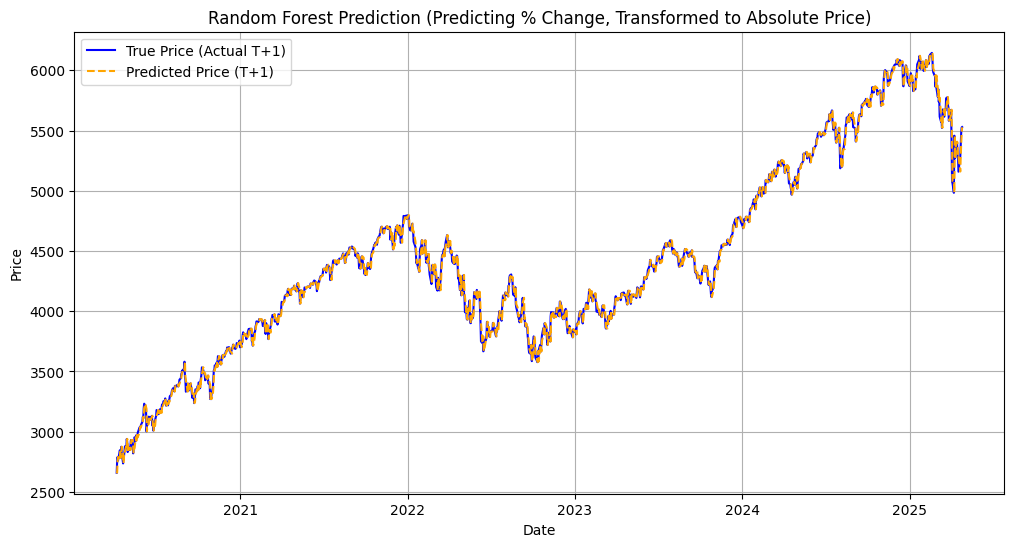

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_absolute_actual.index, y_test_absolute_actual, label='True Price (Actual T+1)', color='blue')
plt.plot(y_test_absolute_actual.index, y_pred_absolute_test, label='Predicted Price (T+1)', color='orange', linestyle='--')
plt.title('Random Forest Prediction (Predicting % Change, Transformed to Absolute Price)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test_absolute_actual, y_pred_absolute_test)
mae = mean_absolute_error(y_test_absolute_actual, y_pred_absolute_test)
mape= np.mean(np.abs((y_test_absolute_actual - y_pred_absolute_test) / y_test_absolute_actual)) * 100
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Absolute Percentage Error: {mape}%")

Mean Squared Error: 2443.038699250463
Mean Absolute Error: 35.27608465199129
Mean Absolute Percentage Error: 0.8219374484601323%
